# Covid-19 Data Cleaning

Preprocessing for the covid-19 statistics project. This notebook includes a detailed discussion of the invalid values in some fields in order to judge how to properly handle these values. 

Most of the functionality of this notebook will be imlemented in a much shorter function in a .py file that will be run at the beginning of each notebook in this project. 

In [1]:
# configure settings
%reset -f
%config InlineBackend.figure_format = 'svg'

# basics
import numpy as np
import pandas as pd
import datetime
import re

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

# fontsizes for plots
BIG_TEXT   = 18
MED_TEXT   = 14
SMALL_TEXT = 10

Load the dataset of new COVID-19 cases and deaths

In [2]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')
df.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


Analyze the columns and evaluate data quality

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090872 entries, 0 to 1090871
Data columns (total 17 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   uid                            1090872 non-null  int64  
 1   location_type                  1090872 non-null  object 
 2   fips_code                      1087602 non-null  float64
 3   location_name                  1090218 non-null  object 
 4   state                          1090872 non-null  object 
 5   date                           1090872 non-null  object 
 6   total_population               1052940 non-null  float64
 7   cumulative_cases               1090872 non-null  int64  
 8   cumulative_cases_per_100_000   1052940 non-null  float64
 9   cumulative_deaths              1090872 non-null  int64  
 10  cumulative_deaths_per_100_000  1052940 non-null  float64
 11  new_cases                      1087536 non-null  float64
 12  new_deaths    

On first look, we see several issues with this dataset: 

1) some column names are particularly long, so we'll rename them

2) some columns contain null values

3) we need to check that columns with the *object* datatype are the correct type (i.e. strings)
    
4) fips_code and total_population are expected to be integers

begin by renaming certain columns

In [4]:
df.rename(columns={
    'cumulative_cases_per_100_000': 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000': 'cumulative_deaths_1e6',
    'new_cases_per_100_000': 'new_cases_1e6', 
    'new_deaths_per_100_000': 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg': 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg': 'new_deaths_7day'
    
}, inplace=True)

Summary of columns and expected data types

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | numpy.int64
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float

Examine each column and verify correct numbers- look for null values or numbers that don't make sense

Count the number of nulls in each column

In [5]:
nulls = df.apply(lambda x: x.isnull().value_counts()).loc[True]
print(nulls)

uid                          NaN
location_type                NaN
fips_code                 3270.0
location_name              654.0
state                        NaN
date                         NaN
total_population         37932.0
cumulative_cases             NaN
cumulative_cases_1e6     37932.0
cumulative_deaths            NaN
cumulative_deaths_1e6    37932.0
new_cases                 3336.0
new_deaths                3336.0
new_cases_1e6            41152.0
new_deaths_1e6           41152.0
new_cases_7day           20143.0
new_deaths_7day          17331.0
Name: True, dtype: float64


Let's get a more visual description of how these nulls are distributed

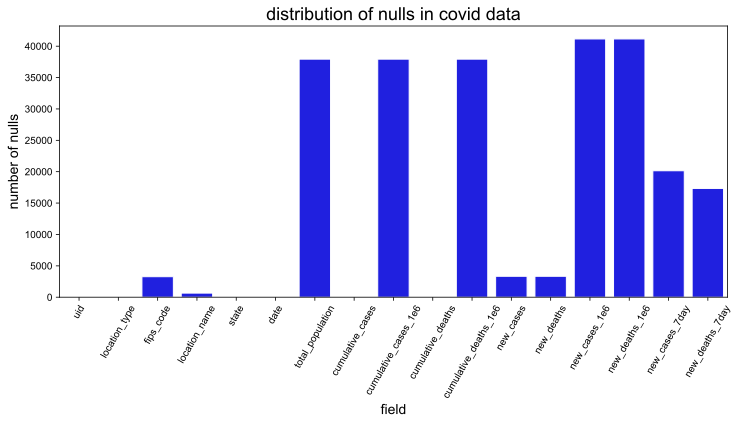

In [6]:
fig, ax = plt.subplots(figsize=[12, 5])
sns.set_style('darkgrid')
sns.barplot(x=nulls.index, y=nulls.values, ax=ax, color='b')
plt.xticks(rotation=60)
ax.set_ylabel("number of nulls", fontsize=MED_TEXT)
ax.set_xlabel("field", fontsize=MED_TEXT)
ax.set_title("distribution of nulls in covid data", fontsize=BIG_TEXT);

Write a function to check for nulls, datatypes, and sensible range of values

In [7]:
def check_values(series, expected_dtype, check_negs=True, name='Series'):
    """Check that the input array is of the expected datatype , and check for negative values
    
    Parameters
    ------------
    series: input pandas series
    expected_dtype: expected datatype for output message
    check_negs: boolean to check for negative values
    name: name of column for output
    """
    print(f"checking {name}:")
    types = set([type(i) for i in series.values])
    print(f"datatypes (expect {expected_dtype}): {types}")
    
    nulls = series.isnull().sum()
    print(f"number of nulls: {nulls}")
    
    if check_negs: 
        num_negative = (series.values < 0).sum()
        print(f"number of negative values: {num_negative}")
    print("=================================================\n")

**uid**

In [8]:
check_values(df['uid'], "int", name='uid')

checking uid:
datatypes (expect int): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**location_type**


In [9]:
check_values(df['location_type'], "string", name="location_type", check_negs=False)

checking location_type:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



get a list of all the location types to see if we might want to throw anything out

In [10]:
# location type
loc_types = df['location_type'].unique()
print(loc_types)

['county' 'special_exception' 'out_of_state'
 'count_unassigned_to_location']


drop all records that don't have the location type of "county"

In [11]:
df = df.drop(df[~df['location_type'].isin(['county'])].index)
loc_types = df['location_type'].unique()
print(loc_types)

['county']


**fips_code**

In [12]:
check_values(df['fips_code'], "int", name="fips_code")

checking fips_code:
datatypes (expect int): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



These appear to be stored as floats, but it seems unecessary since these codes are only supposed to be whole numbers. 

Are there any fractional fips codes in this set? If not we can cast the series to integers

In [13]:
all_ints = all([i.is_integer() for i in df['fips_code'].values])
print(f"all decimal components zero? (expect true) {all_ints}")

all decimal components zero? (expect true) True


Convert all fips codes to integers

In [14]:
df['fips_code'] = df['fips_code'].astype(np.int64)
types = set([type(i) for i in df['fips_code'].values])
print(f"datatypes (expect integer): {types}")

datatypes (expect integer): {<class 'numpy.int64'>}


**location_name**

In [15]:
check_values(df['location_name'], "string", name="location_name", check_negs=False)

checking location_name:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



Later in this notebook, we will want to examine the county-level distribution of nulls in some counties. To avoid mis-counting due to multiple counties with the same name (e.g. North Carolina and Virginia both have a Mecklenburg county) we can create a new column to concatenate county and state. 

In [16]:
df['full_loc_name'] = df['location_name'] + ', ' + df['state']
check_values(df['full_loc_name'], "string", name="full_loc_name", check_negs=False)

checking full_loc_name:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



Convert all to lower case

In [17]:
df['location_name'] = df['location_name'].str.lower()

**state**

In [18]:
check_values(df['state'], "string", name="state", check_negs=False)

checking state:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



For this project, we're only considering the 50 states. Are there any territories in this set? (expect 51: all 50 states plus Washington, DC)

In [19]:
len(df['state'].unique())

52

In [20]:
df['state'].unique()

array(['Puerto Rico', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

Let's remove Puerto Rico

In [21]:
df.drop(df[df['state']=='Puerto Rico'].index, inplace=True)
len(df['state'].unique())

51

**date**

In [22]:
check_values(df['date'], "datetime", name="date", check_negs=False)

checking date:
datatypes (expect datetime): {<class 'str'>}
number of nulls: 0



These dates are stored as strings instead of datetime objects, so lets convert them 

In [23]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [24]:
check_values(df['date'], "datetime", name="date", check_negs=False)

checking date:
datatypes (expect datetime): {<class 'numpy.datetime64'>}
number of nulls: 0



Check that we have the proper range of dates

In [25]:
min(df['date'])

Timestamp('2020-01-22 00:00:00')

In [26]:
max(df['date'])

Timestamp('2020-12-13 00:00:00')

**total_population**

In [27]:
check_values(df['total_population'], "integer", name="total_population")

checking total_population:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



It doesn't make sense for the total population to be a fractional number, so convert these to integers. First, check that all of the populations are actually whole numbers. 

In [28]:
integers = any([~i.is_integer() for i in df['total_population'].values])
print(f"all decimal components zero? (expect true) {integers}")

all decimal components zero? (expect true) True


now convert to integers

In [29]:
df['total_population'] = df['total_population'].astype(np.int64)
check_values(df['total_population'], "integer", name="total_population")

checking total_population:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**cumulative_cases**

In [30]:
check_values(df['cumulative_cases'], "integer", name="cumulative_cases")

checking cumulative_cases:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**cumulative_cases_1e6**

In [31]:
check_values(df['cumulative_cases_1e6'], "float", name="cumulative_cases_1e6")

checking cumulative_cases_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



**cumulative_deaths**

In [32]:
check_values(df['cumulative_deaths'], "integer", name="cumulative_deaths")

checking cumulative_deaths:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**cumulative_deaths_1e6**

In [33]:
check_values(df['cumulative_deaths_1e6'], "float", name="cumulative_deaths_1e6")

checking cumulative_deaths_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



**new_cases and new_deaths** 

For the sake of brevity, we'll look at new_cases and new_deaths at the same time

In [34]:
check_values(df['new_cases'], "integer", name="new_cases")
check_values(df['new_deaths'], "integer", name="new_deaths")

checking new_cases:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 3142
number of negative values: 12216

checking new_deaths:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 3142
number of negative values: 3175



Is there a particular pattern to where these NaNs and negative numbers are located?

In [35]:
num_states_case_negative = len(df['state'][df['new_cases']<0].unique())
num_states_case_null = len(df['state'][df['new_cases'].isnull()].unique())
num_states_death_negative = len(df['state'][df['new_deaths']<0].unique())
num_states_death_null = len(df['state'][df['new_deaths'].isnull()].unique())

num_counties_case_negative = len(df['location_name'][df['new_cases']<0].unique())
num_counties_case_null = len(df['location_name'][df['new_cases'].isnull()].unique())
num_counties_death_negative = len(df['location_name'][df['new_deaths']<0].unique())
num_counties_death_null = len(df['location_name'][df['new_deaths'].isnull()].unique())

neg_county_case_ratio =  num_counties_case_negative / len(df['location_name'].unique())*100
null_county_case_ratio = num_counties_case_null     / len(df['location_name'].unique())*100
neg_county_death_ratio =  num_counties_death_negative / len(df['location_name'].unique())*100
null_county_death_ratio = num_counties_death_null     / len(df['location_name'].unique())*100

arrays = [['negative', 'negative', 'null', 'null'], ['# states', '% counties', '# states', '% counties']]
tuples = list(zip(*arrays))
cols = pd.MultiIndex.from_tuples(tuples, names=['type', 'level'])

index = ['cases', 'deaths']

data = [
    [num_states_case_negative, neg_county_case_ratio, num_states_case_null, null_county_case_ratio],
    [num_states_death_negative, neg_county_death_ratio, num_states_death_null, null_county_death_ratio]
]

invalids = pd.DataFrame(data=data, index=index, columns=cols)
invalids

type   negative                null           
level  # states % counties # states % counties
cases        50  87.221316       51      100.0
deaths       50  49.374660       51      100.0

For both new cases and new deaths, most states have recorded a negative value and **all** counties have nulls. 

On what dates did these null values occur? 

In [36]:
dates_null_cases = df['date'][df['new_cases'].isnull()].value_counts()
dates_null_deaths = df['date'][df['new_deaths'].isnull()].value_counts()

print(f"dates for new cases: \n{dates_null_cases}\n")
print(f"dates for new deaths: \n{dates_null_deaths}\n")

dates for new cases: 
2020-01-22    3142
Name: date, dtype: int64

dates for new deaths: 
2020-01-22    3142
Name: date, dtype: int64



Every instance of a null in new_cases and new_deaths occur on the first day that data was collected, so we can simply set those to zero

In [37]:
df['new_cases'].fillna(value=0, inplace=True)
df['new_deaths'].fillna(value=0, inplace=True)

Now, let's investigate where these new_cases and new_deaths are negative

In [38]:
neg_cases = df[df['new_cases']<0]
neg_deaths = df[df['new_deaths']<0]

In [39]:
neg_cases.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name
28109,84001011,county,1011,bullock,Alabama,2020-12-01,10352,701,6771.64,19,183.54,-1.0,0.0,-9.66,0.0,2.00,0.00,"Bullock, Alabama"
30391,84001025,county,1025,clarke,Alabama,2020-11-24,24387,1553,6368.15,19,77.91,-1.0,0.0,-4.10,0.0,7.83,0.00,"Clarke, Alabama"
30706,84001027,county,1027,clay,Alabama,2020-11-12,13378,825,6166.84,13,97.17,-1.0,0.0,-7.47,0.0,3.33,0.00,"Clay, Alabama"
45774,84001119,county,1119,sumter,Alabama,2020-12-08,12985,622,4790.14,22,169.43,-1.0,0.0,-7.70,0.0,6.17,0.00,"Sumter, Alabama"
47389,84001129,county,1129,washington,Alabama,2020-11-18,16643,878,5275.49,17,102.15,-2.0,0.0,-12.02,0.0,6.50,0.71,"Washington, Alabama"


In [40]:
neg_deaths.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name
26249,84001001,county,1001,autauga,Alabama,2020-04-20,55200,28,50.72,1,1.81,2.0,-1.0,3.62,-1.81,1.29,0.17,"Autauga, Alabama"
26260,84001001,county,1001,autauga,Alabama,2020-05-01,55200,43,77.90,3,5.43,1.0,-1.0,1.81,-1.81,1.00,0.33,"Autauga, Alabama"
26279,84001001,county,1001,autauga,Alabama,2020-05-20,55200,135,244.57,3,5.43,5.0,-1.0,9.06,-1.81,6.43,0.00,"Autauga, Alabama"
26414,84001001,county,1001,autauga,Alabama,2020-10-02,55200,1812,3282.61,27,48.91,13.0,-1.0,23.55,-1.81,8.86,0.50,"Autauga, Alabama"
26449,84001001,county,1001,autauga,Alabama,2020-11-06,55200,2257,4088.77,30,54.35,13.0,-1.0,23.55,-1.81,14.71,0.00,"Autauga, Alabama"


On cursory inpection, there doesn't seem to be a particular pattern. Let's try visualizing how these values are distributed among the states. 

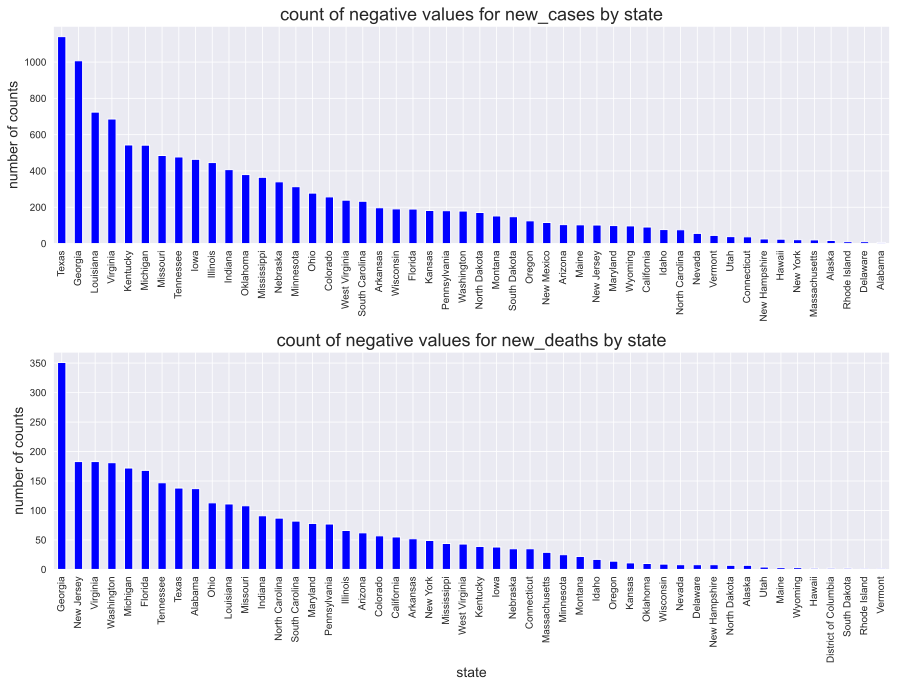

In [41]:
fig, ax = plt.subplots(nrows=2, figsize=[15,10])

plt.subplots_adjust(hspace=0.5)
neg_cases['state'].value_counts().plot.bar(ax=ax[0], color='b')
neg_deaths['state'].value_counts().plot.bar(ax=ax[1], color='b')

ax[0].set_title("count of negative values for new_cases by state", fontsize=BIG_TEXT)
ax[0].set_ylabel("number of counts", fontsize=MED_TEXT)

ax[1].set_title("count of negative values for new_deaths by state", fontsize=BIG_TEXT)
ax[1].set_xlabel("state", fontsize=MED_TEXT)
ax[1].set_ylabel("number of counts", fontsize=MED_TEXT);

Aside from Georgia on the new_deaths plot, no single state is giving an overwhelmingly large contribution to the negative values for new_deaths, but there is a clear distribution.

How many negative values are present for any given day? Are there a few days that reported lots of negative values or are they evenly distributed?  

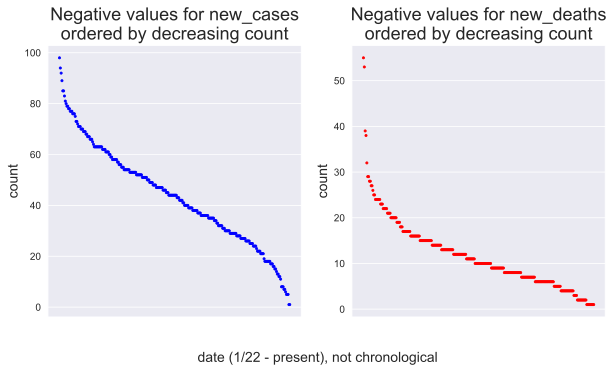

In [42]:
date_case_counts = neg_cases['date'].value_counts()
date_death_counts = neg_deaths['date'].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=[10,5])

sns.scatterplot(x=date_case_counts.index.strftime(date_format='%Y-%m-%d'), 
                y=date_case_counts, 
                ax=ax[0], 
                edgecolor=None, 
                s=5,
                color='b')


sns.scatterplot(x=date_death_counts.index.strftime(date_format='%Y-%m-%d'), 
                y=date_death_counts, 
                ax=ax[1], 
                edgecolor=None,
                s=5, 
                color='r')

ax[0].set_ylabel("count", fontsize=MED_TEXT)
ax[0].set(xticklabels=[])
ax[0].grid(axis='x')
ax[0].set_title("Negative values for new_cases\nordered by decreasing count", fontsize=BIG_TEXT)
ax[1].set_ylabel("count", fontsize=MED_TEXT)
ax[1].set(xticklabels=[])
ax[1].grid(axis='x')
ax[1].set_title("Negative values for new_deaths\nordered by decreasing count", fontsize=BIG_TEXT)
fig.text(0.5, 0, 'date (1/22 - present), not chronological', ha='center', fontsize=MED_TEXT);

It appears that a few dates have many negative values. 

How are these negatives distributed over time? 

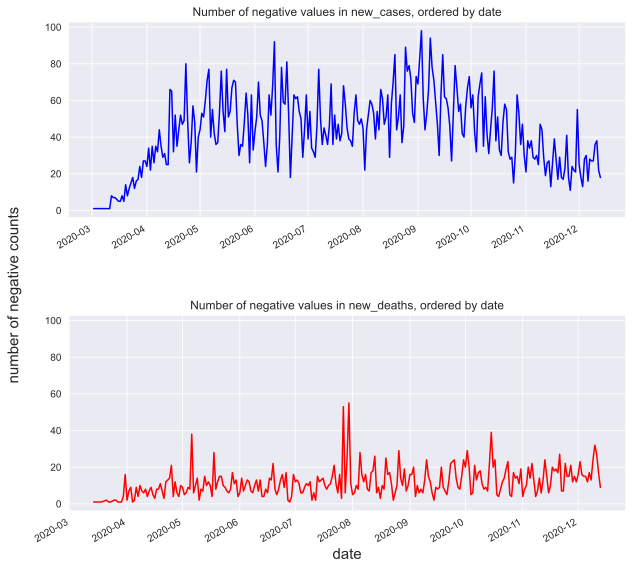

In [43]:
date_case_counts = neg_cases['date'].value_counts()
date_death_counts = neg_deaths['date'].value_counts()

fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)

date_case_counts.sort_index().plot.line(ax=ax[0], color='b')
date_death_counts.sort_index().plot.line(ax=ax[1], color='r')

ax[0].set_title("Number of negative values in new_cases, ordered by date")
ax[1].set_title("Number of negative values in new_deaths, ordered by date")


fig.text(0.04, 0.5, 'number of negative counts', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

These spikes in negative numbers appear to occur on a weekly basis. The number of negative values reported in new_cases has been graduallly decreasing since September, which may suggest improvements in either recording or data mapping from local data sources to Johns Hopkins' database. 

negative values in new_deaths seem to peak in late September. Other than that, they seem to be relatively constant

What days of the week see the most negative values in new_deaths and new_cases? 

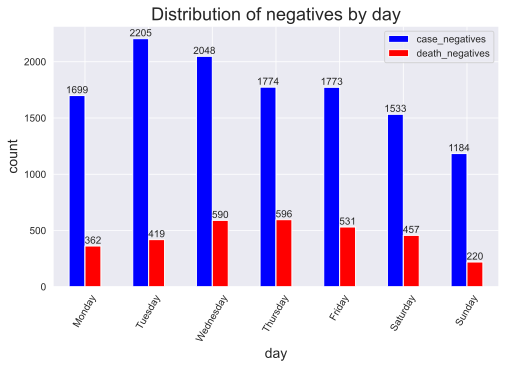

In [44]:
days = {
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday', 
    5: 'Saturday', 
    6: 'Sunday'
}
    
negative_data = {'day': [days[i] for i in range(0, 7)], 
                 'case_negatives': [sum(neg_cases['new_cases'][neg_cases['date'].dt.dayofweek==day].value_counts()) 
                                    for day in range(0, 7)],
                 'death_negatives': [sum(neg_deaths['new_deaths'][neg_deaths['date'].dt.dayofweek==day].value_counts()) 
                                    for day in range(0, 7)]}



negatives_by_day = pd.DataFrame(data=negative_data, columns=['case_negatives', 'death_negatives'], index=negative_data['day'])

fig, ax = plt.subplots(figsize=[8, 4.8])
negatives_by_day.plot.bar(ax=ax, color=['b', 'r'])
ax.set_title("Distribution of negatives by day", fontsize=BIG_TEXT)
ax.set_ylabel("count", fontsize=MED_TEXT)
ax.set_xlabel("day", fontsize=MED_TEXT)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),                             
               (p.get_x()+p.get_width()/2., p.get_height()),   
                fontsize=SMALL_TEXT,
                ha='center',                              
                va='center',                              
                xytext=(0, 5),                               
                textcoords='offset points')
plt.xticks(rotation=60);

Code for bar labels taken from leroygr's solution on stackoverflow: https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

Most negatives in new_cases appear on Tuesdays and most of the negatives on new deaths appear on Wednesdays, but not by a particularly large margin on cursory inspection. 

Now we examine the actual values. Are all these on the order of -1 or -2 or are there any larger values involved? 

In [45]:
case_values = neg_cases['new_cases'].value_counts()
death_values = neg_deaths['new_deaths'].value_counts()

print(f"value counts for invalid cases\n{case_values.head()}\n")
print(f"value counts for invalid deaths\n{death_values.head()}\n")

value counts for invalid cases
-1.0    8474
-2.0    1660
-3.0     605
-4.0     298
-5.0     217
Name: new_cases, dtype: int64

value counts for invalid deaths
-1.0    2634
-2.0     262
-3.0      89
-4.0      63
-5.0      33
Name: new_deaths, dtype: int64



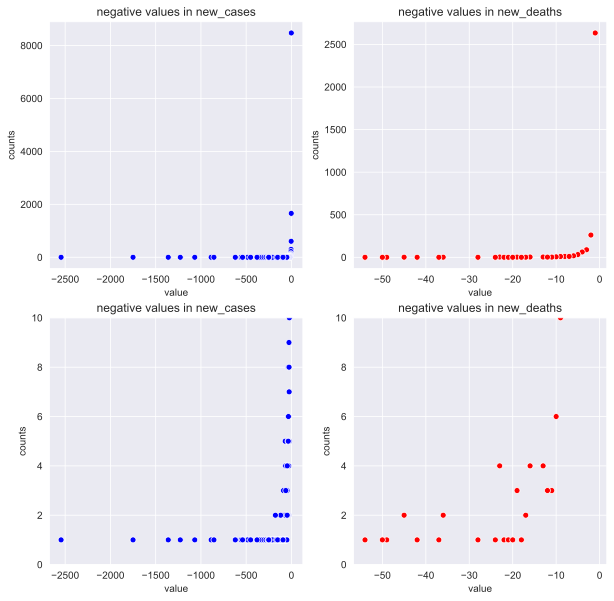

In [46]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=([10,10]))

for i in [0,1]:
    sns.scatterplot(x=neg_cases['new_cases'].value_counts().index, 
                    y=neg_cases['new_cases'].value_counts().values, 
                    color='b', 
                    ax=ax[i][0])
    sns.scatterplot(x=neg_deaths['new_deaths'].value_counts().index, 
                    y=neg_deaths['new_deaths'].value_counts().values, 
                    color='r', 
                    ax=ax[i][1])

    ax[i][0].set_title("negative values in new_cases")
    ax[i][0].set_ylabel("counts")
    ax[i][0].set_xlabel("value")
    ax[i][1].set_title("negative values in new_deaths")
    ax[i][1].set_ylabel("counts")
    ax[i][1].set_xlabel("value"); 
ax[1][0].set_ylim([0, 10]);
ax[1][1].set_ylim([0, 10]);

As expected, the vast majority are only at -1 or -2 for both new_cases and new_deaths. However, there are a few instances of particularly large negative values which have the potential to influence future modeling. 
 
For the sake of curiosity, let's look at which states and counties are the biggest culprits for these values. We're only interested in large negative values, which we'll call <-100 for cases and <-10 for deaths.  

Where are these large negative values occuring? 

In [47]:
neg_cases[['full_loc_name', 'date', 'new_cases']][neg_cases['new_cases']<-100].sort_values(by='new_cases').head(10)

,full_loc_name,date,new_cases
856004,"Bexar, Texas",2020-09-23,-2545.0
146490,"Orange, Florida",2020-12-08,-1750.0
199762,"Union, Georgia",2020-11-09,-1361.0
896628,"Lamar, Texas",2020-12-08,-1228.0
851421,"Anderson, Texas",2020-09-18,-1068.0
166734,"Decatur, Georgia",2020-11-08,-887.0
1042060,"Sheboygan, Wisconsin",2020-09-16,-856.0
98617,"San Bernardino, California",2020-07-30,-621.0
775315,"Montour, Pennsylvania",2020-12-12,-620.0
609029,"Hudson, New Jersey",2020-06-25,-558.0


In [48]:
neg_deaths[['full_loc_name', 'date', 'new_deaths']][neg_deaths['new_deaths']<-10].sort_values(by='new_deaths').head(10)

,full_loc_name,date,new_deaths
774780,"Montgomery, Pennsylvania",2020-05-18,-54.0
997346,"King, Washington",2020-12-10,-50.0
923014,"Tarrant, Texas",2020-08-29,-49.0
631597,"Kings, New York",2020-06-30,-45.0
608969,"Hudson, New Jersey",2020-04-26,-45.0
767259,"Delaware, Pennsylvania",2020-05-18,-42.0
925270,"Travis, Texas",2020-07-27,-37.0
98996,"San Diego, California",2020-09-20,-36.0
771478,"Lancaster, Pennsylvania",2020-04-16,-36.0
775434,"Northampton, Pennsylvania",2020-05-18,-28.0


From this, we see that Bexas County, Texas and Hudson County, New Jersey are responsible for the largest negative values. In a future version of this project, we'll continue to examine what's going on with these negative values. For now, we need to move on. 

There are only two easy ways of handling this data- set them all to zero or turn them into positive numbers. For now we'll set them to zero (and set all the NaNs to zero as well), however I need to do more research to figure out what actually happend to make a better descision on how to handle these values

In [49]:
df['new_cases'].clip(lower=0, inplace=True)
df['new_deaths'].clip(lower=0, inplace=True)

In [50]:
df['full_loc_name'][df['new_cases_7day'].isnull()].value_counts()

Richmond, Virginia           46
Jones, Texas                 46
West Feliciana, Louisiana    41
Cameron, Louisiana           38
St. Helena, Louisiana        29
                             ..
Shoshone, Idaho               5
Schenectady, New York         5
Pearl River, Mississippi      5
Livingston, Missouri          5
Wayne, Utah                   5
Name: full_loc_name, Length: 3142, dtype: int64

Finally, cast everything to integers- first checking that all new case numbers are whole numbers

In [51]:
case_integers = any([~i.is_integer() for i in df['new_cases'].values])
death_integers = any([~i.is_integer() for i in df['new_deaths'].values])

print(f"new_cases: all decimal components zero? (expect true) {case_integers}")
print(f"new_deaths: all decimal components zero? (expect true) {death_integers}")

new_cases: all decimal components zero? (expect true) True
new_deaths: all decimal components zero? (expect true) True


In [52]:
df['new_cases'] = df['new_cases'].astype(np.int64)
df['new_deaths'] = df['new_deaths'].astype(np.int64)

case_types = set([type(i) for i in df['new_deaths'].values])
print(f"new_cases datatypes (expect integer): {case_types}")

death_types = set([type(i) for i in df['new_deaths'].values])
print(f"new_deaths datatypes (expect integer): {death_types}")

new_cases datatypes (expect integer): {<class 'numpy.int64'>}
new_deaths datatypes (expect integer): {<class 'numpy.int64'>}


In [53]:
check_values(df['new_cases'], "integer", name="new_cases")
check_values(df['new_deaths'], "integer", name="new_deaths")

checking new_cases:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**new_cases_1e6, new_deaths_1e6, new_cases_7day, & new_deaths_7day** 

In [54]:
check_values(df['new_cases_1e6'], "integer", name="new_cases")
check_values(df['new_deaths_1e6'], "integer", name="new_deaths")

checking new_cases:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 3142
number of negative values: 12216

checking new_deaths:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 3142
number of negative values: 3175



This set has the exact same number of nulls and negative values as new_cases and new_deaths, which makes sense since these are calculated fields based on new_cases and new_deaths. Therefore we can apply the exact same treatment.
DOUBLE CHECK THIS PART!!! DO NOT CONVERT TO INTEGERS

In [55]:
df['new_cases_1e6'].clip(lower=0, inplace=True)
df['new_cases_1e6'].fillna(value=0, inplace=True)
df['new_deaths_1e6'].clip(lower=0, inplace=True)
df['new_deaths_1e6'].fillna(value=0, inplace=True)

In [56]:
case_integers = any([~i.is_integer() for i in df['new_cases_1e6'].values])
death_integers = any([~i.is_integer() for i in df['new_deaths_1e6'].values])

print(f"new_cases_1e6: all decimal components zero? (expect true) {case_integers}")
print(f"new_deaths_1e6: all decimal components zero? (expect true) {death_integers}")

new_cases_1e6: all decimal components zero? (expect true) True
new_deaths_1e6: all decimal components zero? (expect true) True


In [57]:
df['new_cases_1e6'] = df['new_cases_1e6'].astype(np.int64)
df['new_deaths_1e6'] = df['new_deaths_1e6'].astype(np.int64)

In [58]:
check_values(df['new_cases_1e6'], "integer", name="new_cases")
check_values(df['new_deaths_1e6'], "integer", name="new_deaths")

checking new_cases:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**new_cases_7day & new_deaths_7day**



In [59]:
check_values(df['new_cases_7day'], "integer", name="new_cases_7day")
check_values(df['new_deaths_7day'], "integer", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 16734
number of negative values: 0

checking new_deaths_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 15776
number of negative values: 0



new_cases_7day and new_deaths_7day have many more nulls than the previous 4 columns. The most likely case is that the 7 day rolling averages are null in the first 6 days of data collection since there weren't enough values to calculate an average. 

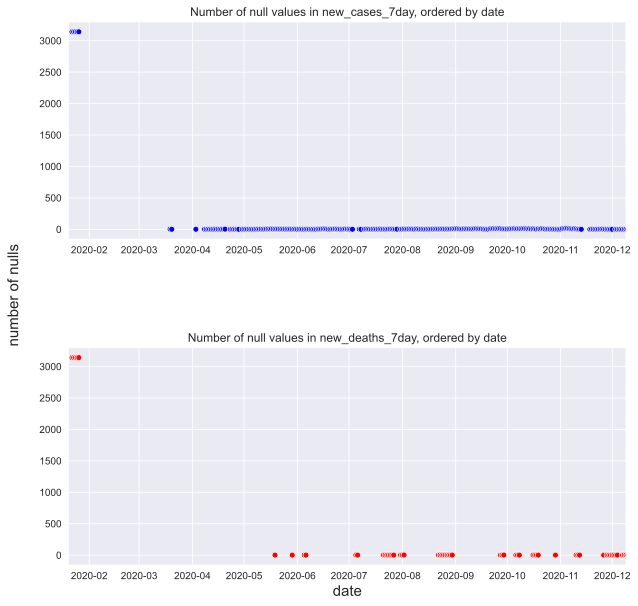

In [60]:
null_case_7day_counts=df['date'][df['new_cases_7day'].isnull()].value_counts().sort_index()
null_death_7day_counts=df['date'][df['new_deaths_7day'].isnull()].value_counts().sort_index()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)


sns.scatterplot(x=null_case_7day_counts.index, 
                y=null_case_7day_counts.values, 
                color='b', 
                ax=ax[0])
sns.scatterplot(x=null_death_7day_counts.index, 
                y=null_death_7day_counts.values,  
                color='r', 
                ax=ax[1])
ax[0].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.to_datetime('2020-12-09', format='%Y-%m-%d')])
ax[1].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.to_datetime('2020-12-09', format='%Y-%m-%d')])

ax[0].set_title("Number of null values in new_cases_7day, ordered by date")
ax[1].set_title("Number of null values in new_deaths_7day, ordered by date")





fig.text(0.04, 0.5, 'number of nulls', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

As expected, the vast majority of these nulls are occuring in the first 7 days, so we can safely set these to zero.

In [61]:
df['new_cases_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')] = \
    df['new_cases_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')].fillna(value=0)

df['new_deaths_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')] = \
    df['new_deaths_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')].fillna(value=0)

<ipython-input-61-c5d9b37ddb6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_cases_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')] = \
<ipython-input-61-c5d9b37ddb6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_deaths_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')] = \


In [62]:
check_values(df['new_cases_7day'], "integer", name="new_cases_7day")
check_values(df['new_deaths_7day'], "integer", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 1024
number of negative values: 0

checking new_deaths_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 66
number of negative values: 0



There are still some nulls present in the dataset. 

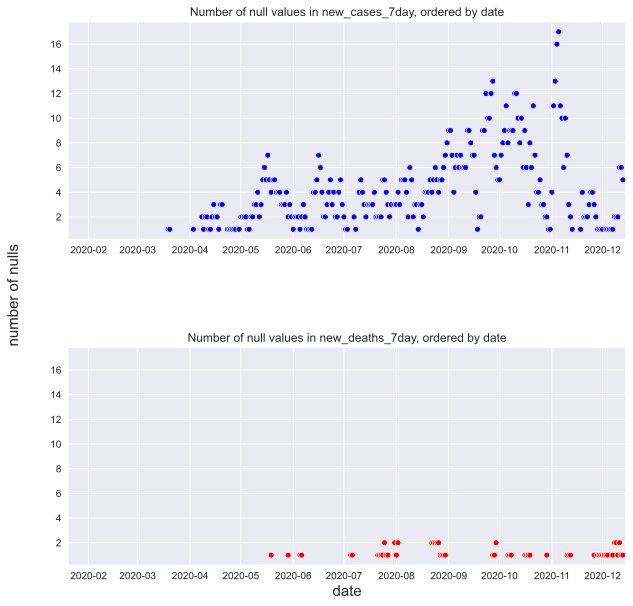

In [63]:
null_case_7day_counts=df['date'][df['new_cases_7day'].isnull()].value_counts().sort_index()
null_death_7day_counts=df['date'][df['new_deaths_7day'].isnull()].value_counts().sort_index()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)


sns.scatterplot(x=null_case_7day_counts.index, 
                y=null_case_7day_counts.values, 
                color='b', 
                ax=ax[0])
sns.scatterplot(x=null_death_7day_counts.index, 
                y=null_death_7day_counts.values,  
                color='r', 
                ax=ax[1])
ax[0].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.Timestamp.today()])
ax[1].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.Timestamp.today()])

ax[0].set_title("Number of null values in new_cases_7day, ordered by date")
ax[1].set_title("Number of null values in new_deaths_7day, ordered by date")





fig.text(0.04, 0.5, 'number of nulls', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

For now, we'll just set all these unexpected null values to zero. In a future iteration of this project we'll look at how these null values are distributed and try to understand why they're there. 

In [64]:
df['new_cases_7day'].fillna(value=0, inplace=True)
df['new_deaths_7day'].fillna(value=0, inplace=True)

In [65]:
check_values(df['new_cases_7day'], "float", name="new_cases_7day")
check_values(df['new_deaths_7day'], "float", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths_7day:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



**new_cases_7day_1e6 & new_deaths_7day_1e6**

Create a new calculated field with the normalized 7 day running averages

In [66]:
df["new_cases_7day_1e6"]  = df['new_cases_7day']   /(df['total_population']/1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] /(df['total_population']/1e5)

In [67]:
check_values(df['new_cases_7day_1e6'], "integer", name="new_cases_7day_1e6")
check_values(df['new_deaths_7day_1e6'], "integer", name="new_deaths_7day_1e6")

checking new_cases_7day_1e6:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths_7day_1e6:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



# Policy Data

Load a dataset which categorizes the various covid-19 responses throughout the country. At the moment, this is a static csv file stored locally. In a future update, I'll make a live connection to the data source.

source: https://healthdata.gov/dataset/covid-19-state-and-county-policy-orders

In [68]:
df2 = pd.read_csv('state_policy_updates_20201114_0719.csv')
df2.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,NY,Bronx,36005.0,county,2020-06-08,Non-Essential Businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...,NaN
1,DE,NaN,NaN,state,2020-03-27,Modify Medicaid Requirements With 1135 Waivers...,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
2,FL,NaN,NaN,state,2020-03-18,Allow Expand Medicaid Telehealth Coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
3,MI,Delta,26041.0,county,2020-07-31,Entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...,NaN
4,NE,Box Butte,31013.0,county,2020-03-30,Shelter in Place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual,NaN


column-wise evaluation

In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   state_id      3458 non-null   object 
 1   county        1812 non-null   object 
 2   fips_code     1812 non-null   float64
 3   policy_level  3458 non-null   object 
 4   date          3458 non-null   object 
 5   policy_type   3458 non-null   object 
 6   start_stop    3458 non-null   object 
 7   comments      3458 non-null   object 
 8   source        3458 non-null   object 
 9   total_phases  639 non-null    float64
dtypes: float64(2), object(8)
memory usage: 270.3+ KB


**state_id**

In [70]:
check_values(df2['state_id'], "string", name="state_id", check_negs=False)

checking state_id:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



This dataset uses data abbreviations instead of full names. To make it easier to join with the case dataset, we should convert these Id's to full names using a prewritten dictionary found here: https://gist.github.com/rogerallen/1583593#file-us_state_abbrev-py

In [71]:
direct = %pwd
%run $direct\\us_state_abbrev.py
print(f"testing: abbreviation for California is {us_state_abbrev['California']}")

Wisconsin --> WI? True
WI --> Wisconsin? True
Number of entries (50 states, DC, 5 Territories) == 56?  True
testing: abbreviation for California is CA


Remove US territories to restrict the data to only the 50 states

In [72]:
us_state_abbrev.pop('American Samoa');
us_state_abbrev.pop('Guam');
us_state_abbrev.pop('Northern Mariana Islands');
us_state_abbrev.pop('Virgin Islands');
us_state_abbrev.pop('Puerto Rico');
      
abbrev_us_state.pop('AS');
abbrev_us_state.pop('GU');
abbrev_us_state.pop('MP');
abbrev_us_state.pop('VI');
abbrev_us_state.pop('PR');

In [73]:
df2 = df2.drop(df2[~df2['state_id'].isin(abbrev_us_state)].index)

re-name state id to have the full state name

In [74]:
df2.replace(to_replace=abbrev_us_state, inplace=True)

In [75]:
df2.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,New York,Bronx,36005.0,county,2020-06-08,Non-Essential Businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...,NaN
1,Delaware,NaN,NaN,state,2020-03-27,Modify Medicaid Requirements With 1135 Waivers...,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
2,Florida,NaN,NaN,state,2020-03-18,Allow Expand Medicaid Telehealth Coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
3,Michigan,Delta,26041.0,county,2020-07-31,Entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...,NaN
4,Nebraska,Box Butte,31013.0,county,2020-03-30,Shelter in Place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual,NaN


**county**

In [76]:
check_values(df2['county'], "string", name="county", check_negs=False)

checking county:
datatypes (expect string): {<class 'float'>, <class 'str'>}
number of nulls: 1606



nulls in the county field refer to statewide policies, so we'll change the null values to reflect that. Aditionally, convert all these counties to lowercase

In [77]:
df2['county'].fillna(value='statewide', inplace=True)
df2['county'] = df2['county'].str.lower()

Check that all the counties in df2 are also present in df

In [78]:
locs = df['location_name'].unique()
mismatches = [county for county in df2['county'][df2['county']!='statewide'].unique() 
              if county not in locs]
print(mismatches)

['frio county', 'osage county', 'colusa county', 'erie county', 'greene county', 'aransas county', 'starr county', 'wichita county', 'shawnee county', 'lafayette county', 'anderson county', 'hardin county', 'orange county', 'gadsden county', 'castro county', 'andrews county', 'jefferson county', 'summit county', 'lehigh county', 'dougherty county', 'marion county', 'saline county', 'brown county', 'coryell county', 'montgomery county', 'henderson county', 'angelina county', 'warren county', 'dane county', 'galveston county', 'floyd county', 'willacy county', 'platte county', 'maui county', 'san patricio county', 'crawford county', 'milam county', 'bee county', 'collin county', 'stanislaus county', 'newton county', 'iron county', 'clayton county', 'mendocino county', 'forest county', 'westmoreland county', 'skagway municipality', 'arapahoe county', 'fort bend county', 'riverside county', 'adams county', 'kleberg county', 'hidalgo county', 'san jacinto county', 'deaf smith county', 'sono

There are some slight differences in location names. For example, frio county in the policy dataset is written as frio in the case dataset. Remove the modifiers at the end of the location names so they match the case dataset

In [79]:
county_match    = re.compile(" county$")
munici_match    = re.compile(" municipality$")
city_match      = re.compile(" city$")
Borough_match   = re.compile(" borough$")

df2['county'].replace(to_replace= county_match, value='', inplace=True)
df2['county'].replace(to_replace= munici_match, value='', inplace=True)
df2['county'].replace(to_replace=   city_match, value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)

In [80]:
locs = df['location_name'].unique()
mismatches = [county for county in df2['county'][df2['county']!='statewide'].unique() 
              if county not in locs]
print(mismatches)

[]


In [81]:
check_values(df2['county'], "string", name="county", check_negs=False)

checking county:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



**fips_code**

In [82]:
check_values(df2['fips_code'], "integer", name="fips_code")

checking fips_code:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 1606
number of negative values: 0



**policy_level**

In [83]:
check_values(df2['policy_level'], "string", name="policy_level", check_negs=False)

checking policy_level:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



**date**

In [84]:
check_values(df2['date'], "datetime", name="date", check_negs=False)

checking date:
datatypes (expect datetime): {<class 'str'>}
number of nulls: 0



convert these dates to strings like in case_data

In [85]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

Drop any policies that may have been implemented before the start of the case dataset.

In [86]:
start_date = min(df['date'])
df2.drop(df2[df2['date'] < start_date].index, inplace=True)

In [87]:
check_values(df2['date'], "datetime", name="date", check_negs=False)

checking date:
datatypes (expect datetime): {<class 'numpy.datetime64'>}
number of nulls: 0



**policy_type**

In [88]:
check_values(df2['policy_type'], "string", name="policy_type", check_negs=False)

checking policy_type:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



Policy_type will be heavily used later on, so let's investigate what kind of policies are in this dataset

In [89]:
print(np.sort((df2['policy_type'].unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'New Phase' 'Non-Essential Businesses' 'Nursing Home Visitations'
 'Nursing Homes' 'Order Freezing Utility Shut Offs'
 'Outdoor and Recreation' 'Personal Care' 'Phase 1' 'Phase 2' 'Phase 2, 3'
 'Phase 3' 'Phase 3 Step 2' 'Phase 4' 'Phase 5' 'Public Gatherings'
 'Public Health Advisory System' 'Quarantine'
 '

Some of these names are a bit too long. Rename any policy type longer than 40 characters

In [90]:
long_names = [policy for policy in df2['policy_type'].unique() if len(policy)>40]
for i in long_names: 
    print(i)

Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval
Allow Expand Medicaid Telehealth Coverage
Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues
Mandate Face Mask Use By All Individuals In Public Spaces
Mandate Face Mask Use By All Individuals In Public Facing Businesses
Reopened ACA Enrollment Using a Special Enrollment Period
Suspended Elective Medical Dental Procedures
Stop Initiation Of Evictions Overall Or Due To Covid Related Issues
Renter Grace Period Or Use Of Security Deposit To Pay Rent


In [91]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues': 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval': 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues': 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses':  'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces': 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period': 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures': 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage': 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent': 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    df2['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)

long_names = [policy for policy in df2['policy_type'].unique() if len(policy)>40]
if len(long_names) == 0: 
    print("no more long names")

no more long names


Some of these policies are also vague and non-specific, so we'll drop these as well 

In [92]:
policies_drop = ["phase 1", "phase 2", "phase 3", "phase 4", "phase 5", "new phase"]
df2 = df2.drop(df2[df2['policy_type'].isin(policies_drop)].index)

**start_stop**

In [93]:
check_values(df2['start_stop'], "string", name="start_stop", check_negs=False)

checking start_stop:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



**comments**

In [94]:
check_values(df2['comments'], "string", name="comments", check_negs=False)

checking comments:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



**source**

In [95]:
check_values(df2['source'], "string", name="source", check_negs=False)

checking source:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



**total_phases**

In [96]:
check_values(df2['total_phases'], "integer", name="total_phases", check_negs=False)

checking total_phases:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 2796



Not all policies can be expected to be associated with a specific phase, so we can set those to zero

In [97]:
df2['total_phases'].fillna(value=0, inplace=True)

Are there any decimal values in total_phases? 

In [98]:
phase_integers = any([~i.is_integer() for i in df2['total_phases'].values])
print(f"phases: all decimal components zero? (expect true) {phase_integers}")

phases: all decimal components zero? (expect true) True


In [99]:
df2['total_phases'] = df2['total_phases'].astype(np.int64)
check_values(df2['total_phases'], "integer", name="total_phases", check_negs=False)

checking total_phases:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0

